In [1]:
import sys
sys.path.append("..")
sys.path.append("../src")



In [2]:
import cv2

import tensorflow as tf
from tensorflow_wavelets.utils.models import *
from tensorflow_wavelets.utils.mse import *
from tensorflow_wavelets.utils.data import *

import numpy as np
import pandas as pd
from scipy.stats import entropy
from matplotlib import pyplot as plt

2024-07-08 09:21:09.934438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /localdrive/users/timorl/.conda/envs/py38/lib/python3.8/site-packages/cv2/../../lib64:
2024-07-08 09:21:09.934451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
img = cv2.imread("../src/input/Lenna_orig.png", 0)
img = cv2.resize(img, (240, 240))
img_t = np.expand_dims(img, axis=-1)
img_ex = np.expand_dims(img_t, axis=0)
print(img_ex.shape)

levels = 5
concat = 0
conv_type = "VALID"
border_padd = "SYMMETRIC"
figsize = (20,10)



(1, 240, 240, 1)


In [4]:
def calculate_entropy(matrix):
    # Ensure the matrix is a numpy array with float32 values
    matrix = np.array(matrix, dtype=np.float32)

    # Normalize the matrix to ensure it represents a valid probability distribution
    matrix = matrix / np.sum(matrix, axis=1, keepdims=True)

    # Avoid log(0) by replacing zeros with a small positive value
    matrix = np.maximum(matrix, np.finfo(float).eps)

    # Calculate the entropy for each row
    row_entropy = -np.sum(matrix * np.log2(matrix), axis=1)

    # Total entropy is the average of row entropies
    total_entropy = np.mean(row_entropy)

    return total_entropy


def pyramid_avg_pool_2d(input, levels=4, entop_dic: dict={}):
    plt.figure()
    fig, axs = plt.subplots(1, levels, figsize=figsize)
    fig.suptitle(f'AveragePooling2D')
    entop_dic["AveragePooling2D"] = {}
    for idx in range(levels):
        entop_calc = calculate_entropy(input[0,:,:,0])
        axs[idx].set_title(f"level {idx}:\n {entop_calc}")
        entop_dic["AveragePooling2D"][f"level {idx}"] = entop_calc
        axs[idx].imshow(input[0,:,:,0], cmap='gray')
        input = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(tf.dtypes.cast(input, tf.float32))
        axs[idx].axis("off")
        axs[idx].grid(False)
        

def pyramid(layer, input, levels=4, entop_dic: dict={}):
    plt.figure()
    fig, axs = plt.subplots(1, levels, figsize=figsize)
    fig.suptitle(f'{layer.wavelet_name}')
    entop_dic["DWT-" + layer.wavelet_name] = {}
    for idx in range(levels):
        entop_calc = calculate_entropy(input[0,:,:,0])
        entop_dic["DWT-" + layer.wavelet_name][f"level {idx}"] = entop_calc
        axs[idx].set_title(f"level {idx}:\n {entop_calc}")
        
        axs[idx].imshow(input[0,:,:,0], cmap='gray')
        axs[idx].axis("off")
        axs[idx].grid(False)
        
        coeffs = layer(tf.dtypes.cast(input, tf.float32))
        LL1 = coeffs[:,:,:,0]
        input = np.expand_dims(LL1, axis=-1)   
          


2024-07-08 09:21:11.587398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /localdrive/users/timorl/.conda/envs/py38/lib/python3.8/site-packages/cv2/../../lib64:
2024-07-08 09:21:11.587412: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-08 09:21:11.587424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (epgd039): /proc/driver/nvidia/version does not exist
2024-07-08 09:21:11.587606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 640x480 with 0 Axes>

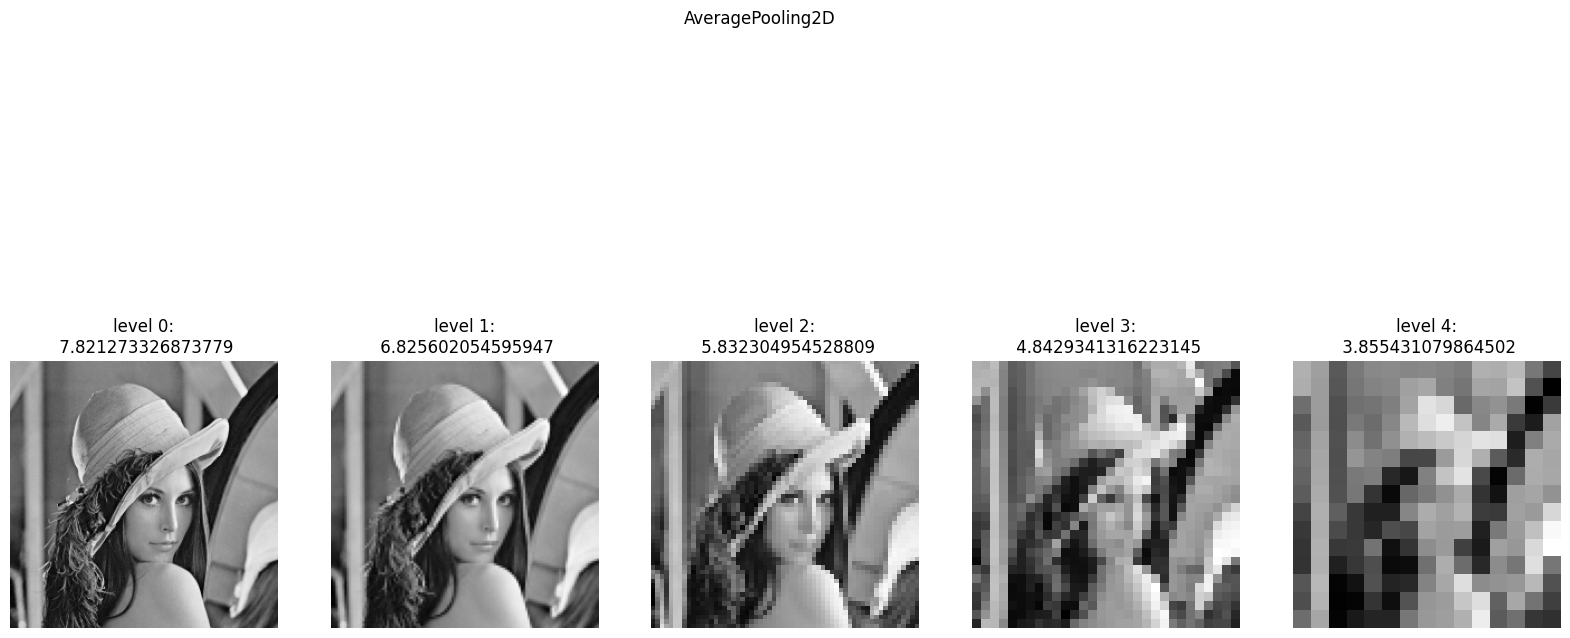

<Figure size 640x480 with 0 Axes>

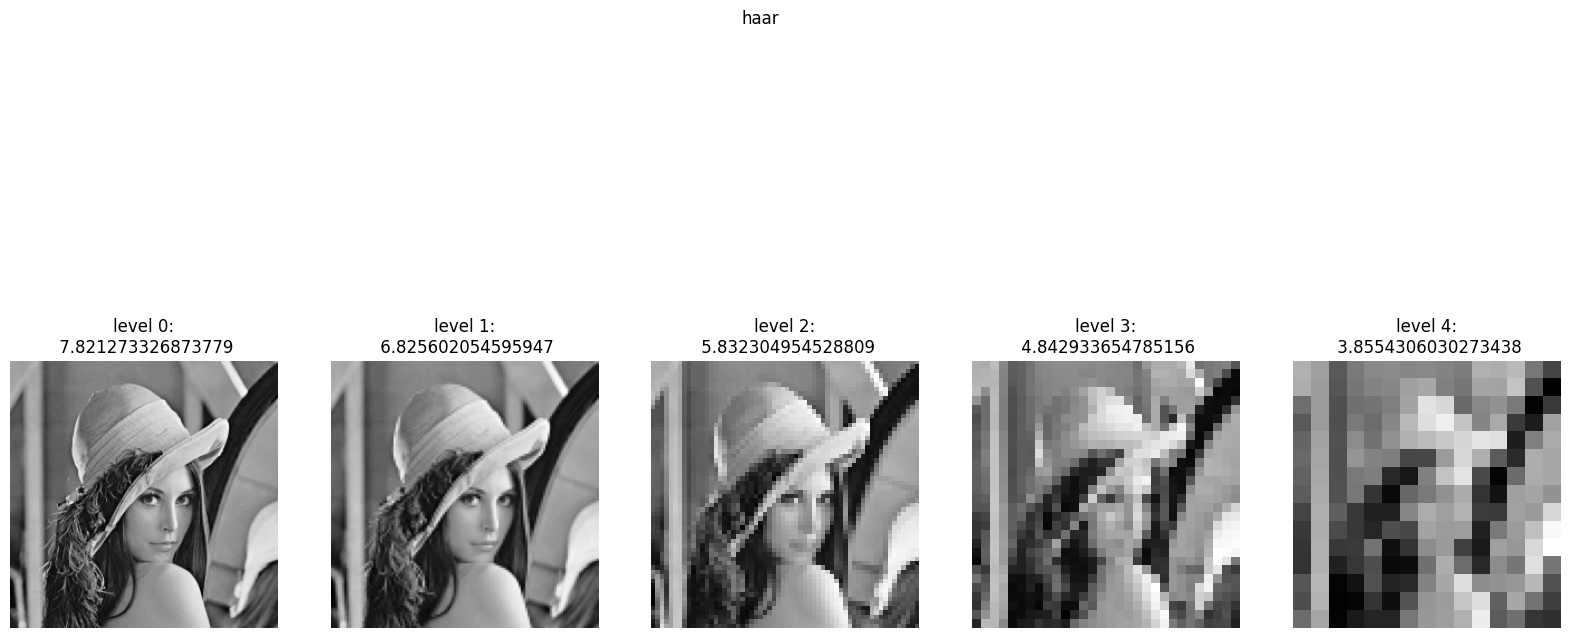

<Figure size 640x480 with 0 Axes>

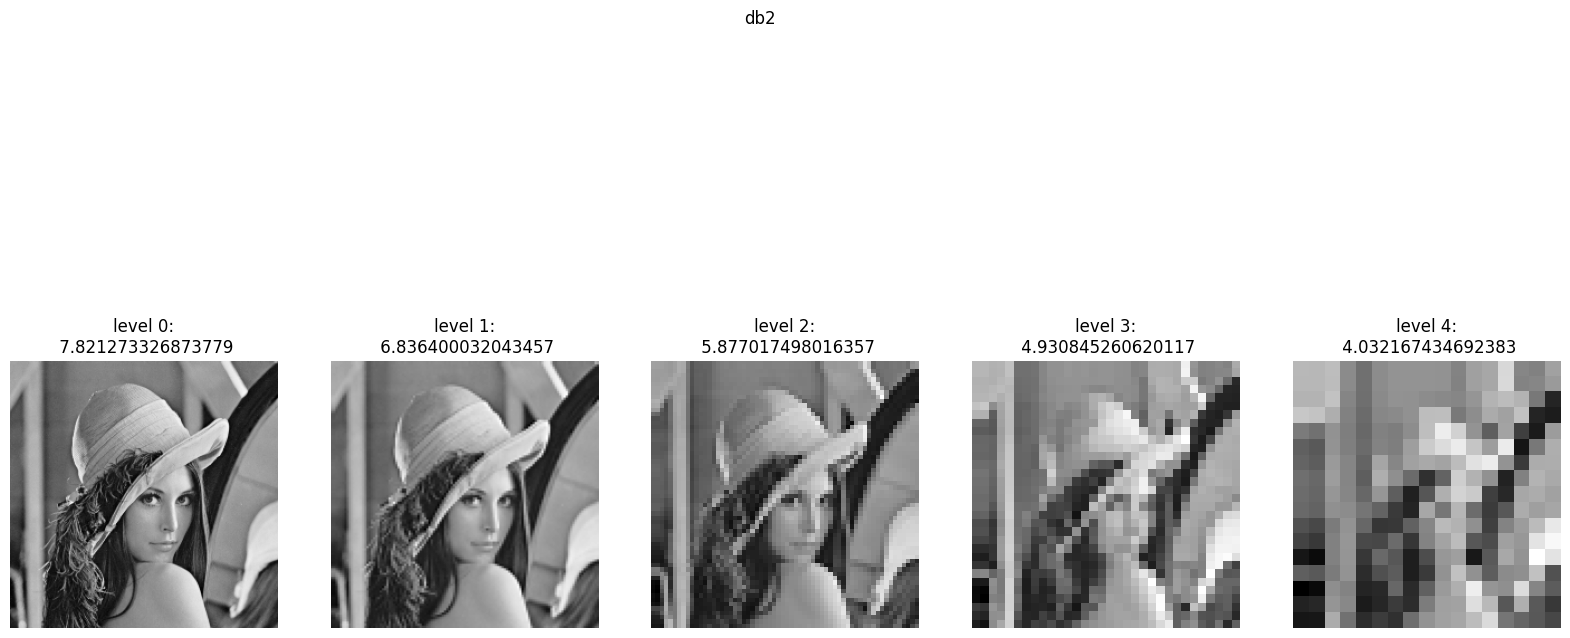

<Figure size 640x480 with 0 Axes>

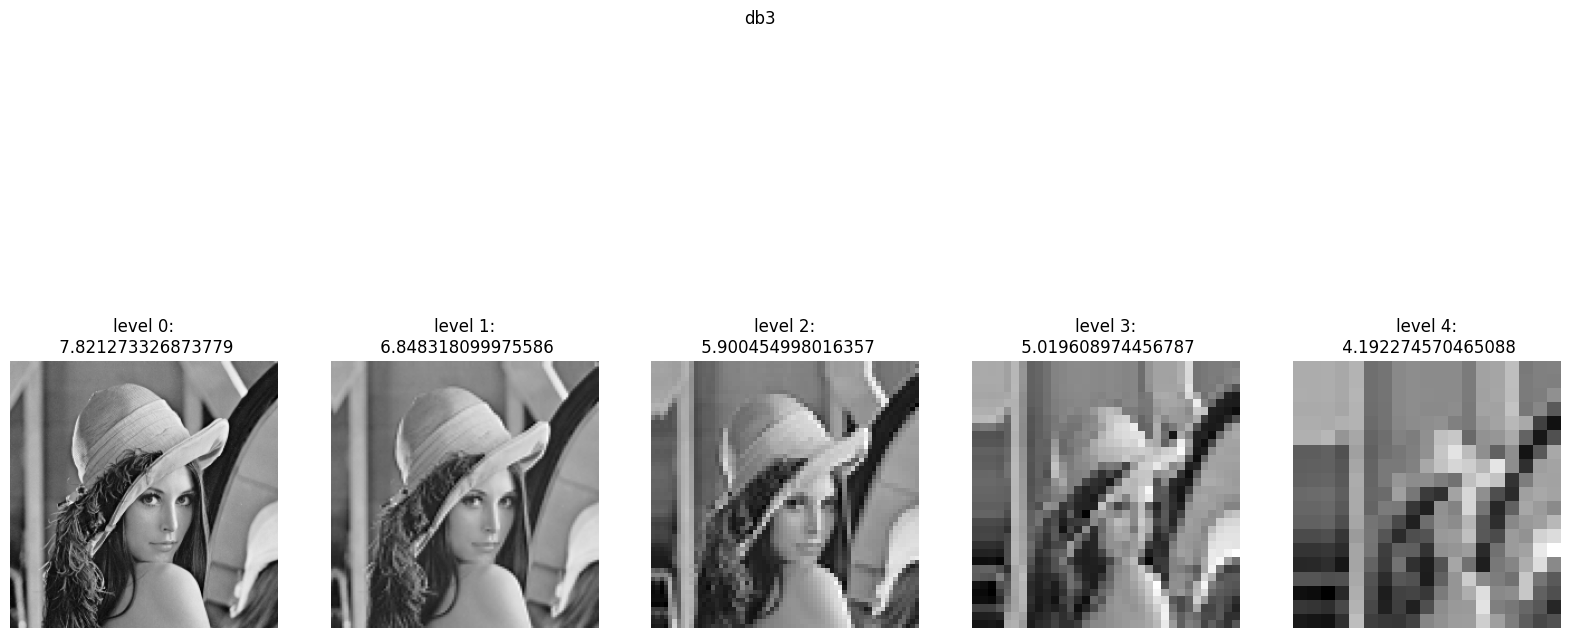

<Figure size 640x480 with 0 Axes>

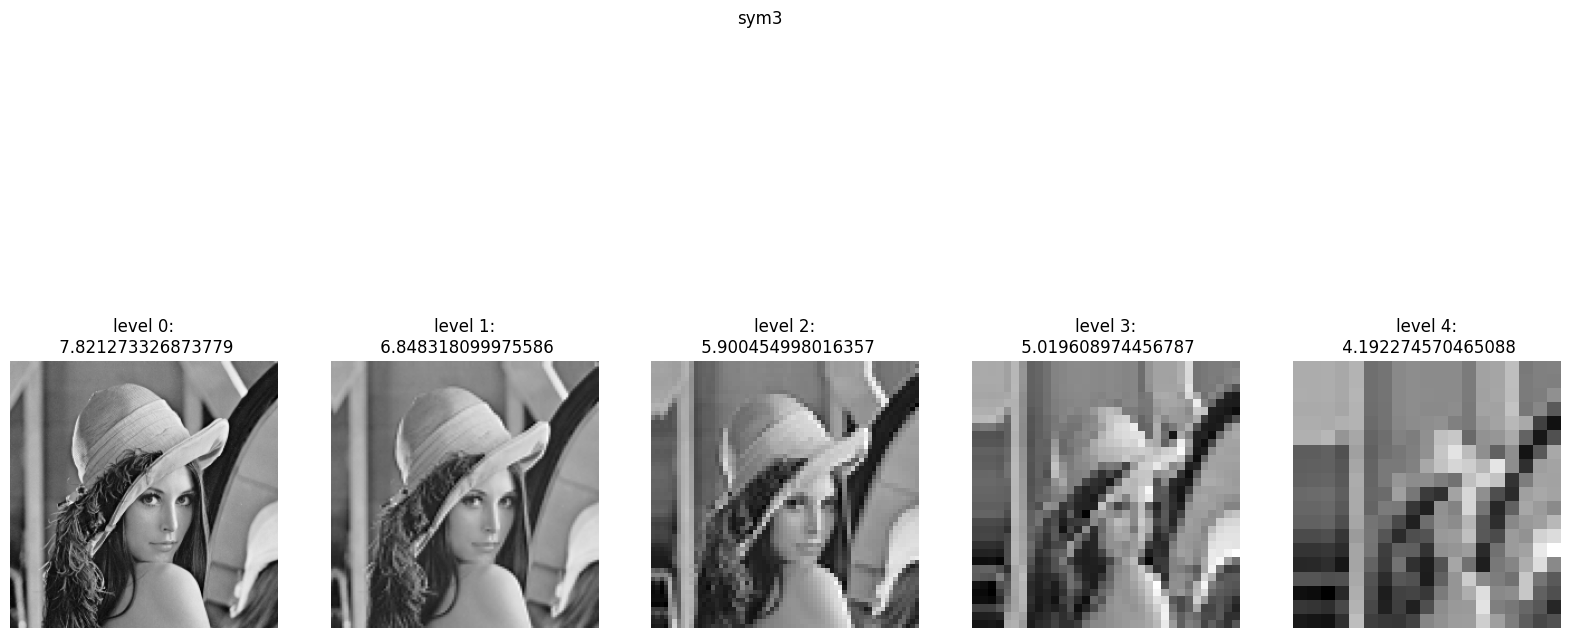

<Figure size 640x480 with 0 Axes>

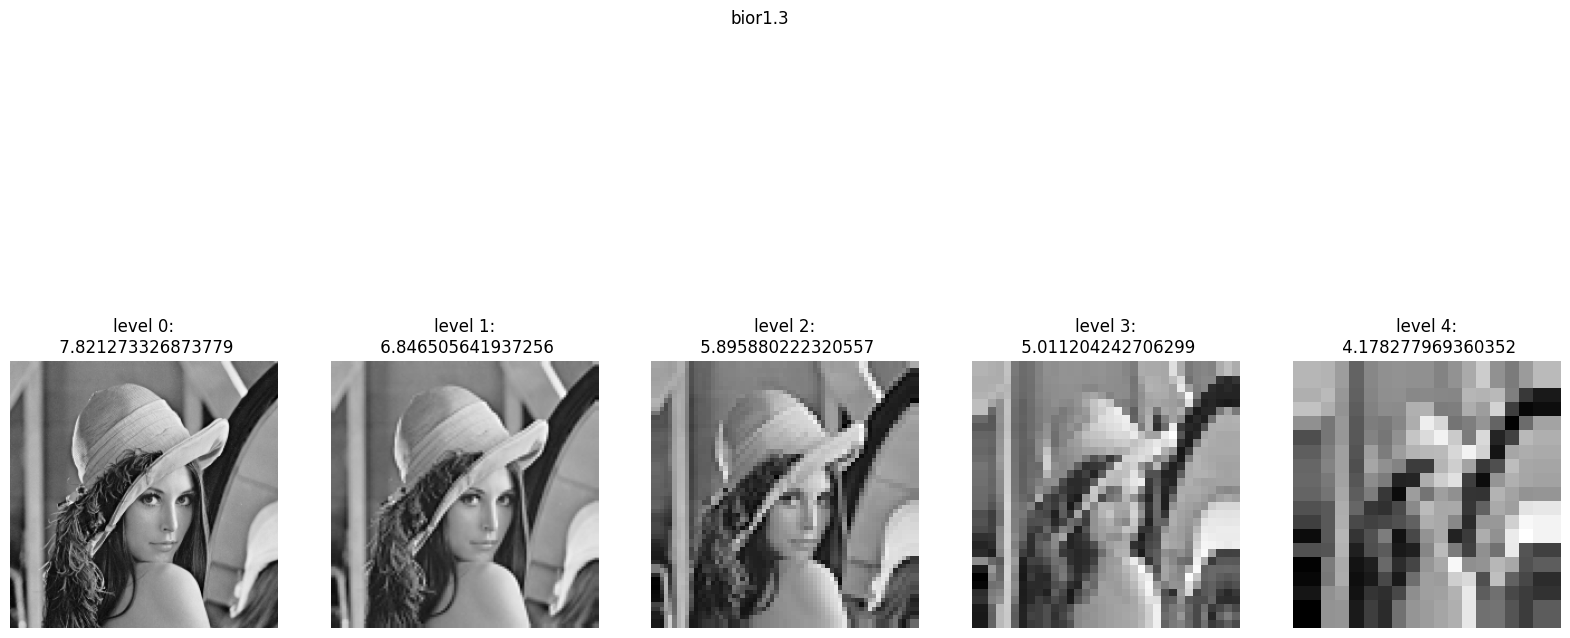

In [5]:
res = dict()
pyramid_avg_pool_2d(img_ex, levels, res)
pyramid(DWT.DWT("haar", concat), img_ex, levels, res)
pyramid(DWT.DWT("db2", concat), img_ex, levels, res)
pyramid(DWT.DWT("db3", concat), img_ex, levels, res)
pyramid(DWT.DWT("sym3", concat), img_ex, levels, res)
pyramid(DWT.DWT("bior1.3", concat), img_ex, levels, res)


In [6]:
df = pd.DataFrame(res)
df

,AveragePooling2D,DWT-haar,DWT-db2,DWT-db3,DWT-sym3,DWT-bior1.3
level 0,7.821273,7.821273,7.821273,7.821273,7.821273,7.821273
level 1,6.825602,6.825602,6.836400,6.848318,6.848318,6.846506
level 2,5.832305,5.832305,5.877017,5.900455,5.900455,5.895880
level 3,4.842934,4.842934,4.930845,5.019609,5.019609,5.011204
level 4,3.855431,3.855431,4.032167,4.192275,4.192275,4.178278


In [9]:
print(df.to_latex(caption="Information at different levels of decomposition for various mother wavelets", label="tab:wavelet_info", position="ht", index=True))

\begin{table}[ht]
\centering
\caption{Information at different levels of decomposition for various mother wavelets}
\label{tab:wavelet_info}
\begin{tabular}{lrrrrrr}
\toprule
{} &  AveragePooling2D &  DWT-haar &   DWT-db2 &   DWT-db3 &  DWT-sym3 &  DWT-bior1.3 \\
\midrule
level 0 &          7.821273 &  7.821273 &  7.821273 &  7.821273 &  7.821273 &     7.821273 \\
level 1 &          6.825602 &  6.825602 &  6.836400 &  6.848318 &  6.848318 &     6.846506 \\
level 2 &          5.832305 &  5.832305 &  5.877017 &  5.900455 &  5.900455 &     5.895880 \\
level 3 &          4.842934 &  4.842934 &  4.930845 &  5.019609 &  5.019609 &     5.011204 \\
level 4 &          3.855431 &  3.855431 &  4.032167 &  4.192275 &  4.192275 &     4.178278 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3094927/920638380.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(caption="Information at different levels of decomposition for various mother wavelets", label="tab:wavelet_info", position="ht", index=True))
